In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

In [4]:
vgg = VGG16()

In [5]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)

In [6]:
predict_image_using_vgg('../img/ectoplasma/image-2.jpeg', vgg)

('n01704323', 'triceratops', 0.38118923)
('n02692877', 'airship', 0.14737095)
('n04552348', 'warplane', 0.100872725)
('n03724870', 'mask', 0.099860534)
('n03935335', 'piggy_bank', 0.045417152)


## Création du DataSet

In [7]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im)
            preprocessed = preprocess_input(img_to_array(im))
            image_arrays.append(preprocessed)
            all_labels.append(class_id)
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [8]:
X, Y, filenames, all_images = create_dataset('../img')

0 bulbizarre
1 dracaufeu
2 ectoplasma
3 lucario
4 pikachu


#### Notre dataset contient 5 classes de pokemon.

In [9]:
X.shape

(324, 224, 224, 3)

Nous avons un total de 324 images avec :
- bulbizarre, 56 images
- dracaufeu, 43 images
- ectoplasma, 75 images
- lucario, 77 images
- pikachu, 73 images

In [10]:
X.shape, Y.shape, len(filenames), len(all_images)

((324, 224, 224, 3), (324, 5), 324, 324)

In [11]:
Y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [12]:
filenames[:8]

['../img/bulbizarre\\image-10.jpeg',
 '../img/bulbizarre\\image-11.jpeg',
 '../img/bulbizarre\\image-12.jpeg',
 '../img/bulbizarre\\image-13.jpeg',
 '../img/bulbizarre\\image-15.jpeg',
 '../img/bulbizarre\\image-2.jpeg',
 '../img/bulbizarre\\image-20.jpeg',
 '../img/bulbizarre\\image-21.jpeg']

('n03944341', 'pinwheel', 0.98297125)
('n03888257', 'parachute', 0.005690108)
('n03598930', 'jigsaw_puzzle', 0.0029683455)
('n03476684', 'hair_slide', 0.0010100934)
('n02782093', 'balloon', 0.00092186686)


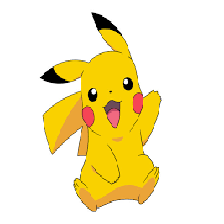

In [13]:
img_id = 323
predict_image_using_vgg(filenames[img_id], vgg)
all_images[img_id]

#### Notre tableau 'filenames' contient bien tous les chemins vers les images
#### Chaque chemin est associé à son id (0 à 323).

#### Ici nous avons conclu que VGG pense que l'image de Pikachu est un "pinwheel" à cause de sa couleur, de la forme de ses oreilles et de sa queue.

### Transfer Learning

In [14]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

# On fixe le nombre de neurones à 20
x = Dense(20, activation='relu')(x) 

# Nous parametrons le nombre de classes 
nb_classes = 5
x = Dense(nb_classes, activation='softmax')(x)  


In [15]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [16]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [17]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [19]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=9, batch_size=5)
# premier essaie : On choisit 9 epochs, 5 batch_size

Instructions for updating:
Use tf.cast instead.
Epoch 1/9
324/324 [==============================] - 233s 719ms/step - loss: 9.3778 - acc: 0.3889
Epoch 2/9
324/324 [==============================] - 231s 712ms/step - loss: 9.0380 - acc: 0.4383
Epoch 3/9
150/324 [============>.................] - ETA: 2:04 - loss: 9.3995 - acc: 0.4133

KeyboardInterrupt: 

#### Nous allons maintenant utiliser notre modèle entrainé pour des prédictions sur les images de test

In [27]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

In [28]:
X_test, test_filenames, test_images = load_test_set(
    '../test_images/')
# Notes images de test se situe sur le répertoire test_images

In [29]:
X_test.shape

(7, 224, 224, 3)

#### Nous avons pris 10 images aléatoirement soit 2 images par classe.


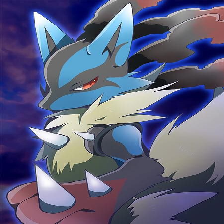

In [30]:
test_id = 0
test_images[test_id]

In [31]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[6.4005140e-10, 2.2128735e-04, 3.4208184e-01, 6.5769690e-01,
        7.0482807e-13]], dtype=float32)


1, ================================================================

In [32]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=9, batch_size=6)
# deuixème essaie : On choisit 9 epochs, 6 batch_size

Epoch 1/9
324/324 [==============================] - 118s 364ms/step - loss: 0.0995 - acc: 0.9938
Epoch 2/9
324/324 [==============================] - 121s 374ms/step - loss: 0.0995 - acc: 0.9938
Epoch 3/9
324/324 [==============================] - 121s 375ms/step - loss: 0.0995 - acc: 0.9938
Epoch 4/9
324/324 [==============================] - 123s 380ms/step - loss: 0.0995 - acc: 0.9938
Epoch 5/9
324/324 [==============================] - 125s 386ms/step - loss: 0.0995 - acc: 0.9938
Epoch 6/9
324/324 [==============================] - 121s 374ms/step - loss: 0.0995 - acc: 0.9938
Epoch 7/9
324/324 [==============================] - 125s 385ms/step - loss: 0.0995 - acc: 0.9938
Epoch 8/9
324/324 [==============================] - 123s 381ms/step - loss: 0.0995 - acc: 0.9938
Epoch 9/9
324/324 [==============================] - 125s 386ms/step - loss: 0.0995 - acc: 0.9938


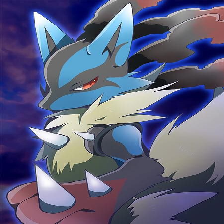

In [35]:
test_id = 0
test_images[test_id]

In [36]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[6.0212368e-10, 1.9833811e-04, 3.2492447e-01, 6.7487717e-01,
        6.2013990e-13]], dtype=float32)

### On peut savoir qu'il n'y a pas beaucoup de différence entre epochs (9, 5) et epochs (9, 6)
============================================================

In [37]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=9, batch_size=18)
# troisième essaie : On choisit 9 epochs, 18 batch_size

Epoch 1/9
324/324 [==============================] - 125s 387ms/step - loss: 0.0995 - acc: 0.9938
Epoch 2/9
324/324 [==============================] - 117s 362ms/step - loss: 0.0995 - acc: 0.9938
Epoch 3/9
324/324 [==============================] - 121s 373ms/step - loss: 0.0995 - acc: 0.9938
Epoch 4/9
324/324 [==============================] - 119s 369ms/step - loss: 0.0995 - acc: 0.9938
Epoch 5/9
324/324 [==============================] - 124s 382ms/step - loss: 0.0995 - acc: 0.9938
Epoch 6/9
324/324 [==============================] - 121s 373ms/step - loss: 0.0995 - acc: 0.9938
Epoch 7/9
324/324 [==============================] - 122s 376ms/step - loss: 0.0995 - acc: 0.9938
Epoch 8/9
324/324 [==============================] - 123s 378ms/step - loss: 0.0995 - acc: 0.9938
Epoch 9/9
324/324 [==============================] - 121s 373ms/step - loss: 0.0995 - acc: 0.9938


In [38]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[5.9152422e-10, 1.9280762e-04, 3.2036233e-01, 6.7944485e-01,
        5.9901791e-13]], dtype=float32)

### Avec (epoch, batch_size) (9, 18), on peut savoir qu'il n'y pas beaucoup de différence avec les essaie 1 et 2, parce que epoch est 9, on a entraîné 9 tour, ça donne le résultat plus exacte.
===========================================================

In [39]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=5)
# essaie 4: On choisit 3 epochs, 5 batch_size

Epoch 1/3
324/324 [==============================] - 113s 349ms/step - loss: 0.0995 - acc: 0.9938
Epoch 2/3
324/324 [==============================] - 136s 420ms/step - loss: 0.0995 - acc: 0.9938
Epoch 3/3
324/324 [==============================] - 115s 356ms/step - loss: 0.0995 - acc: 0.9938


In [ ]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

==========================================================

In [122]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=6)
# essaie 5 : On choisit 3 epochs, 6 batch_size

Epoch 1/3
324/324 [==============================] - 120s 371ms/step - loss: 5.1737 - acc: 0.6790
Epoch 2/3
324/324 [==============================] - 124s 381ms/step - loss: 5.1737 - acc: 0.6790
Epoch 3/3
324/324 [==============================] - 124s 383ms/step - loss: 5.1737 - acc: 0.6790


In [25]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[7.3485840e-10, 2.8528212e-04, 3.9144737e-01, 6.0826737e-01,
        9.6394550e-13]], dtype=float32)

==========================================================

In [24]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=18)
# essaie 6 : On choisit 3 epochs, 18 batch_size

Epoch 1/3
324/324 [==============================] - 138s 426ms/step - loss: 0.0996 - acc: 0.9938
Epoch 2/3
324/324 [==============================] - 149s 459ms/step - loss: 0.0995 - acc: 0.9938
Epoch 3/3
324/324 [==============================] - 143s 442ms/step - loss: 0.0995 - acc: 0.9938


In [23]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[2.0617581e-10, 1.4942282e-18, 1.2106920e-16, 1.0000000e+00,
        4.4113788e-09]], dtype=float32)

=========================================================

In [ ]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=5, batch_size=5)
# essaie 7 : On choisit 5 epochs, 5 batch_size

In [ ]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

=============================================================

In [24]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=5, batch_size=6)
# essaie 8 : On choisit 5 epochs, 6 batch_size

Epoch 1/5
324/324 [==============================] - 85s 263ms/step - loss: 0.3202 - acc: 0.9722
Epoch 2/5
324/324 [==============================] - 90s 277ms/step - loss: 0.1715 - acc: 0.9815
Epoch 3/5
324/324 [==============================] - 94s 291ms/step - loss: 0.1039 - acc: 0.9907
Epoch 4/5
324/324 [==============================] - 95s 294ms/step - loss: 0.6284 - acc: 0.9444
Epoch 5/5
324/324 [==============================] - 94s 289ms/step - loss: 0.4660 - acc: 0.9599


In [25]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[1.2264761e-12, 4.2396635e-24, 2.4720899e-22, 1.0000000e+00,
        4.4787132e-16]], dtype=float32)

==============================================================

In [22]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=5, batch_size=18)
# essaie 9: On choisit 5 epochs, 6 batch_size

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
324/324 [==============================] - 111s 343ms/step - loss: 3.1272 - acc: 0.6481
Epoch 2/5
324/324 [==============================] - 129s 398ms/step - loss: 0.4138 - acc: 0.9383
Epoch 3/5
324/324 [==============================] - 131s 404ms/step - loss: 0.1431 - acc: 0.9846
Epoch 4/5
324/324 [==============================] - 131s 403ms/step - loss: 0.1006 - acc: 0.9938
Epoch 5/5
324/324 [==============================] - 129s 398ms/step - loss: 0.0996 - acc: 0.9938


In [23]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

array([[8.1517293e-10, 2.8757608e-04, 4.1007918e-01, 5.8963329e-01,
        1.0091421e-12]], dtype=float32)

=================================================================

In [ ]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=1, batch_size=6)
# essaie 10: On choisit 5 epochs, 6 batch_size

In [ ]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

======================================================================

In [ ]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=1, batch_size=18)
# essaie 11: On choisit 5 epochs, 18 batch_size

In [ ]:
img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
custom_model.predict(img_reshaped)

========================================================================